##**BIO/QTM 385: In class exercise for Monday, November 15th** 


(answers will be the part of Assignment #6, Due 12/1)

<font color='green'>**Enter your names and group number here.**  </font>

*This notebook contains modified excerpts from the [Hands-One Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurelien Geron; the content is available [on GitHub](https://github.com/ageron/handson-ml2). The code is released under the [Apache-2.0 License](https://github.com/ageron/handson-ml2/blob/master/LICENSE).  In addition, aspects have been adapted from the Neuromatch course materials [here](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md).*

As always, all questions to be answered will be in <font color="blue"> blue</font> and places to write your answers will be in <font color="green"> green</font>.

To start, make sure that you go up to the **Runtime** menu, and make sure that *Hardware Accelerator* is set to *GPU* (otherwise your code will take forever to run)

In [ ]:
!nvidia-smi;

import numpy as np
import os
import numpy.random as random
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.layers as layers
import keras.models as models
from keras.layers import Dense, Input, Flatten, Reshape
from keras.layers import GaussianNoise, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
!pip install umap-learn[plot]
from umap import UMAP
from sklearn.model_selection import train_test_split
K = keras.backend

In [ ]:
# @title Helper Functions & Figure Settings

import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=( n_rows,n_cols))
    for index, image in enumerate(images):
        plt.subplot(n_cols, n_rows,index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(15):
    for k2 in range(15):
      k = k + 1
      plt.imshow(X[k],
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255,cmap='gray')
  plt.xlim((15 * 28, 0))
  plt.ylim((15 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 255])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_training_history(hist):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(hist.history['loss'], label='Training Loss', color='firebrick')
    ax.plot(hist.history['val_loss'], label='Validation Loss', color='royalblue')
    ax.legend(loc='center right')
    ax.set_ylabel("loss")
    ax.set_xlabel("Epoch #")    
    if 'val_accuracy' in hist.history.keys():
        ax2 = ax.twinx()
        ax2.plot(hist.history['accuracy'], '--', label='Training Accuracy', color='firebrick', )
        ax2.plot(hist.history['val_accuracy'], '--', label='Testing Accuracy', color='royalblue')
        ax2.legend(loc='lower left')
        ax2.set_ylabel("accuracy")




def make_fashion_mnist_plot(X_valid_2D,X_valid,y_valid):
  # adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
  cmap = plt.cm.tab10
  x = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
  plt.scatter(x[:, 0], x[:, 1], c=y_valid, s=10, cmap=cmap)
  image_positions = np.array([[1., 1.]])
  for index, position in enumerate(x):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
  plt.axis("off")
  plt.show()


def show_reconstructions(model, images, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])



##Variational Autoencoders



###Introduction

As described in class, variational autoencoders (VAEs) are *generative* and *probabalistic* models that transform inputs (e.g., pixel values) into *latent variables* that are used to create samples that optimially approximate these inputs.  The image below displays a typical example, where inputs are transformed into the parameters of a Gaussian distribution (means, $\{\mu_1,\mu_2,\ldots \mu_k\}$, and variances, $\{\sigma^2_1,\sigma^2_2,\ldots \sigma^2_k\}$) via the encoder network.  Random samples are then made out of this $k$-dimensional Gaussian distribution, and the outputs are then transformed back into the original input space via the decoder network.  The fact that we constrain the latent variable distribution to be a certain type of distribution (often, Gaussian), is why these are called *variational* autoencoders, reminiscent of constrained optimization using the [Calculus of Variations](https://en.wikipedia.org/wiki/Calculus_of_variations) formalism.

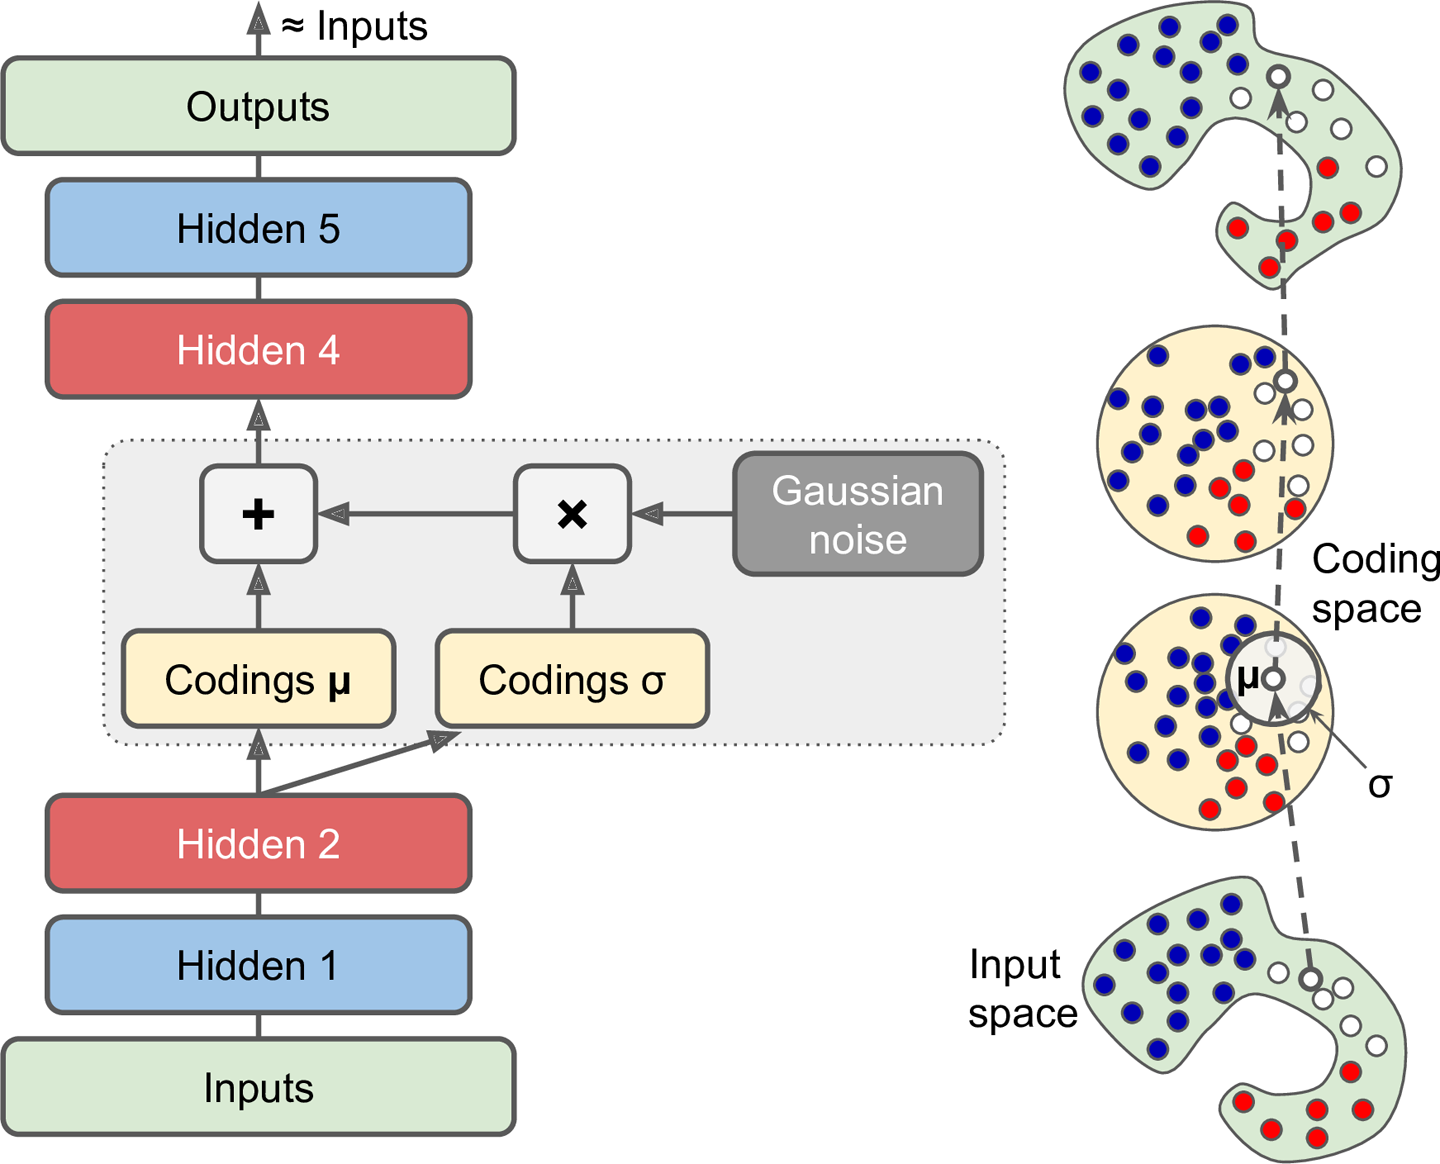

The advantages of this approach are that 1) it can be shown that this process is an efficient manner for calculating approximate Bayesian inference of underlying variables (in the example here, the $\mu$s and $\sigma^2$s), and 2) the process is generative.  If one knows the probability distribution over the latent variables (let's call it $p(\vec{z})$), then it is then possible to sample new data points from the input data by passing samples from this distibtuion through the decoder network. 

###Loss Function

There are generally two parts to a Variational Autoencoder loss function.  First is the typical notion of reconstruction loss (e.g., mean-squared error or cross-entropy between the input and the output values).  This is the same as we saw last time.  The second part of the loss function is related to the variational part of the autoencoder - we call this the *latent loss*.  Namely, we want to minimize the [Kullback-Leibler Divergence](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) between the distribution of the latent variables and the target distribution (e.g., a Gaussian).  

Put together, if we would like our latent variables to be Gaussian-distributed, each with a mean of zero and a variance of 1, we can [write](https://arxiv.org/abs/1606.05908) the overall loss function as:
\begin{equation}
\mathcal{L} = \text{Reconstruction Error} - \frac{1}{2}\sum_{i=1}^k\left[ 1+\log\sigma_i^2 -\sigma_i^2 -\mu_i\right].
\end{equation}
Typically, for numerical stability, we will define a new parameter, $\gamma_i\equiv \log{\sigma_i^2}$, turning the above equation into:
\begin{equation}
\mathcal{L} = \text{Reconstruction Error} - \frac{1}{2}\sum_{i=1}^k\left[ 1+\gamma_i -\exp(\gamma_i) -\mu_i\right].
\end{equation}

Obviously, the form of this loss can get more complicated in cases where we want to have a more complicated distribution of latent variables (or if we want to impose additional constraints like sparsity on the representation), but this notion will be enough for our exercise today -- and it will typically be enough in most real-world scenarios.

##An example: Fasion MNIST

###Loading the data

Like last time, we will use the Fashion MNIST data set as an example.  Let's start by loading the data:

In [ ]:
#Load the Fashion MNIST Data, plot example images, and break into training, test, and validation sets

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data();
plot_MNIST_sample(X_train_full)
X_train_full = X_train_full.astype(np.float32) / 255; #this is to put all of the images between 0 & 1, which is often helpful
X_test = X_test.astype(np.float32) / 255;
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:];
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:];

print('Training Set Shape = '+str(np.shape(X_train))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid))+'\n')
print('Test Set Shape = '+str(np.shape(X_test))+'\n')

###Training the Network

To start, we will define a new layer type, ```Sampling```, that samples and example using a set of means and log(variances).

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

We now can define our model in Keras.  Since a variational model is not sequential, we can't use the ```Sequential``` API, like we did last time.  The method below is referred to as the ```Functional``` API.

As shown below, we first define the ```coding_size```.  This is the dimensionality of latent variable space ($k$ in the equations above).  Here, for starters, we use $k=10$.

From there, we define our encoder, which has the form $784\to 150\to 100\to 10 \text{ coding units}$.  Each of the 10 units in the latent variable layer are expressed via their mean and the logrithm of their variances.   

In [ ]:
codings_size = 10

inputs = layers.Input(shape=[28, 28])
z = layers.Flatten()(inputs)
z = layers.Dense(150, activation="selu")(z)
z = layers.Dense(100, activation="selu")(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

Next, we define the decoder, which takes an identical form to our previous decoders $10\to 100 \to 150 \to 784$.

In [ ]:
decoder_inputs = Input(shape=[codings_size])
x = Dense(100, activation="selu")(decoder_inputs)
x = Dense(150, activation="selu")(x)
x = Dense(28 * 28, activation="sigmoid")(x)
outputs = Reshape([28, 28])(x)
variational_decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

Putting the encoder and the decoder together, we can now create and train our full VAE.  Note how we have defined our *latent loss* in the same manner as in the equations above.

In [ ]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(inputs=[inputs], outputs=[reconstructions])

#define the latent loss
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)
#tell the network to add the latent loss to the cost function when optimizing
variational_ae.add_loss(K.mean(latent_loss) / 784.)

#compiling and running
variational_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
vae_history = variational_ae.fit(X_train, X_train, epochs=40, batch_size=256,validation_data=(X_valid, X_valid))

plot_training_history(vae_history)

###Evaluating the Network Performace

So how well did we do?  One way to check to look at the reconstructions from the network.  You should see that the images look pretty similar, although somewhat blurrier.  

In [ ]:
show_reconstructions(variational_ae,X_valid)
plt.show()

Next, we can plot the hidden state variables in a similar manner we've used previously (note, though, that now the encoder network has multiple outputs, so we only take the third -- the first two are the mean and the log(variance)).

Histogramming each of these 10 latent variables based on applying the network to our training set, we get the plots below.

In [ ]:
_,_,latent_values = variational_encoder.predict(X_train)

plt.rcParams["figure.figsize"] = (15,8)
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.hist(latent_values[:,i],50,density=True)
  plt.xlabel('x_'+str(i))
  plt.ylabel('P(x_'+str(i)+')')
plt.show()

As you likely see, although they're not perfectly Gaussian, they all are Gaussian-ish (to be technical).

<font color=blue> **Question #1**: Calculate and print the mean and standard deviations for each of the 10 latent variables above.  Are the means within sampling error of zero?  How close are the standard deviations to one? </font>

In [ ]:
#Type code for Question #1 here

<font color="green"> Are the means within sampling error of zero?  How close are the standard deviations to one? </font>

<font color=blue> **Question #2**: Calculate and and display the $10\times 10$ covariance matrix for the ```latent_values```.  Describe the structure or that you observe here.  Does it make sense in light of our cost function?</font>

In [ ]:
#Type code for Question #2 here

<font color=green> Describe the structure or that you observe here.  Does it make sense in light of our cost function? </font>

###Generating New Images

Next, we will use the generative capabilities of our variational autoencoder to generate new images that weren't in our original training set but are drawn from the same distribution.

Since we've trained the network to generate samples out a 10-dimensional gaussian without correlations, we can sample randomly out of this distribution to generate images using the code below.

In [ ]:
codings = random.normal(0,1,size=(24, codings_size))
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Note how none of these images are actually in the training or test set - they are examples of things that the model has seen before!  Note how these all look more-or-less like articles of clothing from the Fashion MNIST data.


We can ask more of out model, though.  Let's start with two examples from our training set (here, a shoe and a sheatshirt - with their reconstructions below):

In [ ]:
_,_,z_test = variational_encoder.predict(X_test[:2])
X_test[:2]

z_shoe = z_test[0,:]
z_shirt = z_test[1,:]

show_reconstructions(variational_ae,X_test[:2],2)
plt.show()

From here, we can see how moving along the latent variable space allows us to interpolate between the images.  For example, let's start at the shoe, then slowly interpolate between the images until we reach the sweatshirt.

In [ ]:
num_images = 21

diff_vector = z_shirt - z_shoe
zValues = np.zeros((num_images,10))

for i in range(num_images):
  zValues[i,:] = np.copy(z_shoe) + i*diff_vector/(num_images-1)

new_images = variational_decoder(zValues).numpy()
plot_multiple_images(new_images, 1)

Similarly, we can also interpolate along individual axes.  Below, we see an example of moving within $z_0\in [-4,4]$ and $z_1\in [-4,4]$ (assuming that $z_i=0$ for $i=2,3,\ldots,9$).

In [ ]:
x = np.linspace(-4,4,17)
zValues = np.zeros((17*17,10))
k = 0
for i in range(17):
  for j in range(17):
    zValues[k,0] = x[i]
    zValues[k,1] = x[j]
    k += 1

new_images = variational_decoder(zValues).numpy()
plot_multiple_images(new_images, 17)

<font color=blue> **Question #3**: Train an autoencoder on the Fashion MNIST data set, but only using a coding size of 2 (I might recommend adding an extra layer in between the 100 layer and the sampling layer, but it won't change your results much).  Make a plot similar to the interpolated plot above.  How does this latent space differ from the plot directly above this question.  Why do you think that is?

In [ ]:
#Type your code for Question #3 here

<font color=green> How does this latent space differ from the plot directly above this question.  Why do you think that is?</font>

Now, let's load-in the original MNIST (hand written digits) data set again.

In [ ]:
#load the MNIST data
(X_train_full_mnist, y_train_full_mnist), (X_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data();
plot_MNIST_sample(X_train_full_mnist)
X_train_full_mnist = X_train_full_mnist.astype(np.float32) / 255; #this is to put all of the images between 0 & 1, which is often helpful
X_test_mnist = X_test_mnist.astype(np.float32) / 255;
X_train_mnist, X_valid_mnist = X_train_full_mnist[:-5000], X_train_full_mnist[-5000:];
y_train_mnist, y_valid_mnist = y_train_full_mnist[:-5000], y_train_full_mnist[-5000:];

print('Training Set Shape = '+str(np.shape(X_train_mnist))+'\n')
print('Validation Set Shape = '+str(np.shape(X_valid_mnist))+'\n')
print('Test Set Shape = '+str(np.shape(X_test_mnist))+'\n')

<font color=blue> **Question #4**: Train a VAE on the MNIST data set with a coding length of 2.  Again, describe the 2-d latent variable space as best as you can.  Do you see examples of all 10 digits?

In [ ]:
#Type your code for Question #4 here

<font color=green> Again, describe the 2-d latent variable space as best as you can.  Do you see examples of all 10 digits? </font>

<font color=blue> **Question #5**: One of the fun things about VAEs is that they can allow you to "translate" between data sets.  Here, take your previously-trained networks (use the 2 hidden unit ones) for MNIST and Fashion MNIST and set up a "chimera" encoder that takes hand-written digit inputs and outputs fashion-related images.  Plot a few digit-to-clothes reconstructions from this network using ```show_reconstructions()```. Based on your results from Questions 3 and 4, does your found mapping make sense?

In [ ]:
#Type your code for Question #5 here

<font color=green> Based on your results from Questions 3 and 4, does your found mapping make sense? </font>

<font color=blue> **Question #6**: With all of the neural network methods we've learned about so far, there is always a question of how simple or how complex to make the underlying model.  For the VAEs discussed here, describe how you would perform model selection to determine the number of units in the smallest (i.e., the sampling) layer.

<font color=green> Type your answer for Question #6 here.

<font color=blue> **Question #7**: Now, apply your methodology above to find the "optimal" number of hidden units in the Fashion MNIST VAE.  Show all of your code, and clearly describe your reasoning in words.

In [ ]:
#Type your code for Question #7 here

<font color=green> Clearly describe your reasoning in words. </font>